In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import soundfile as sf
from scipy import signal

In [2]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
                               # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    

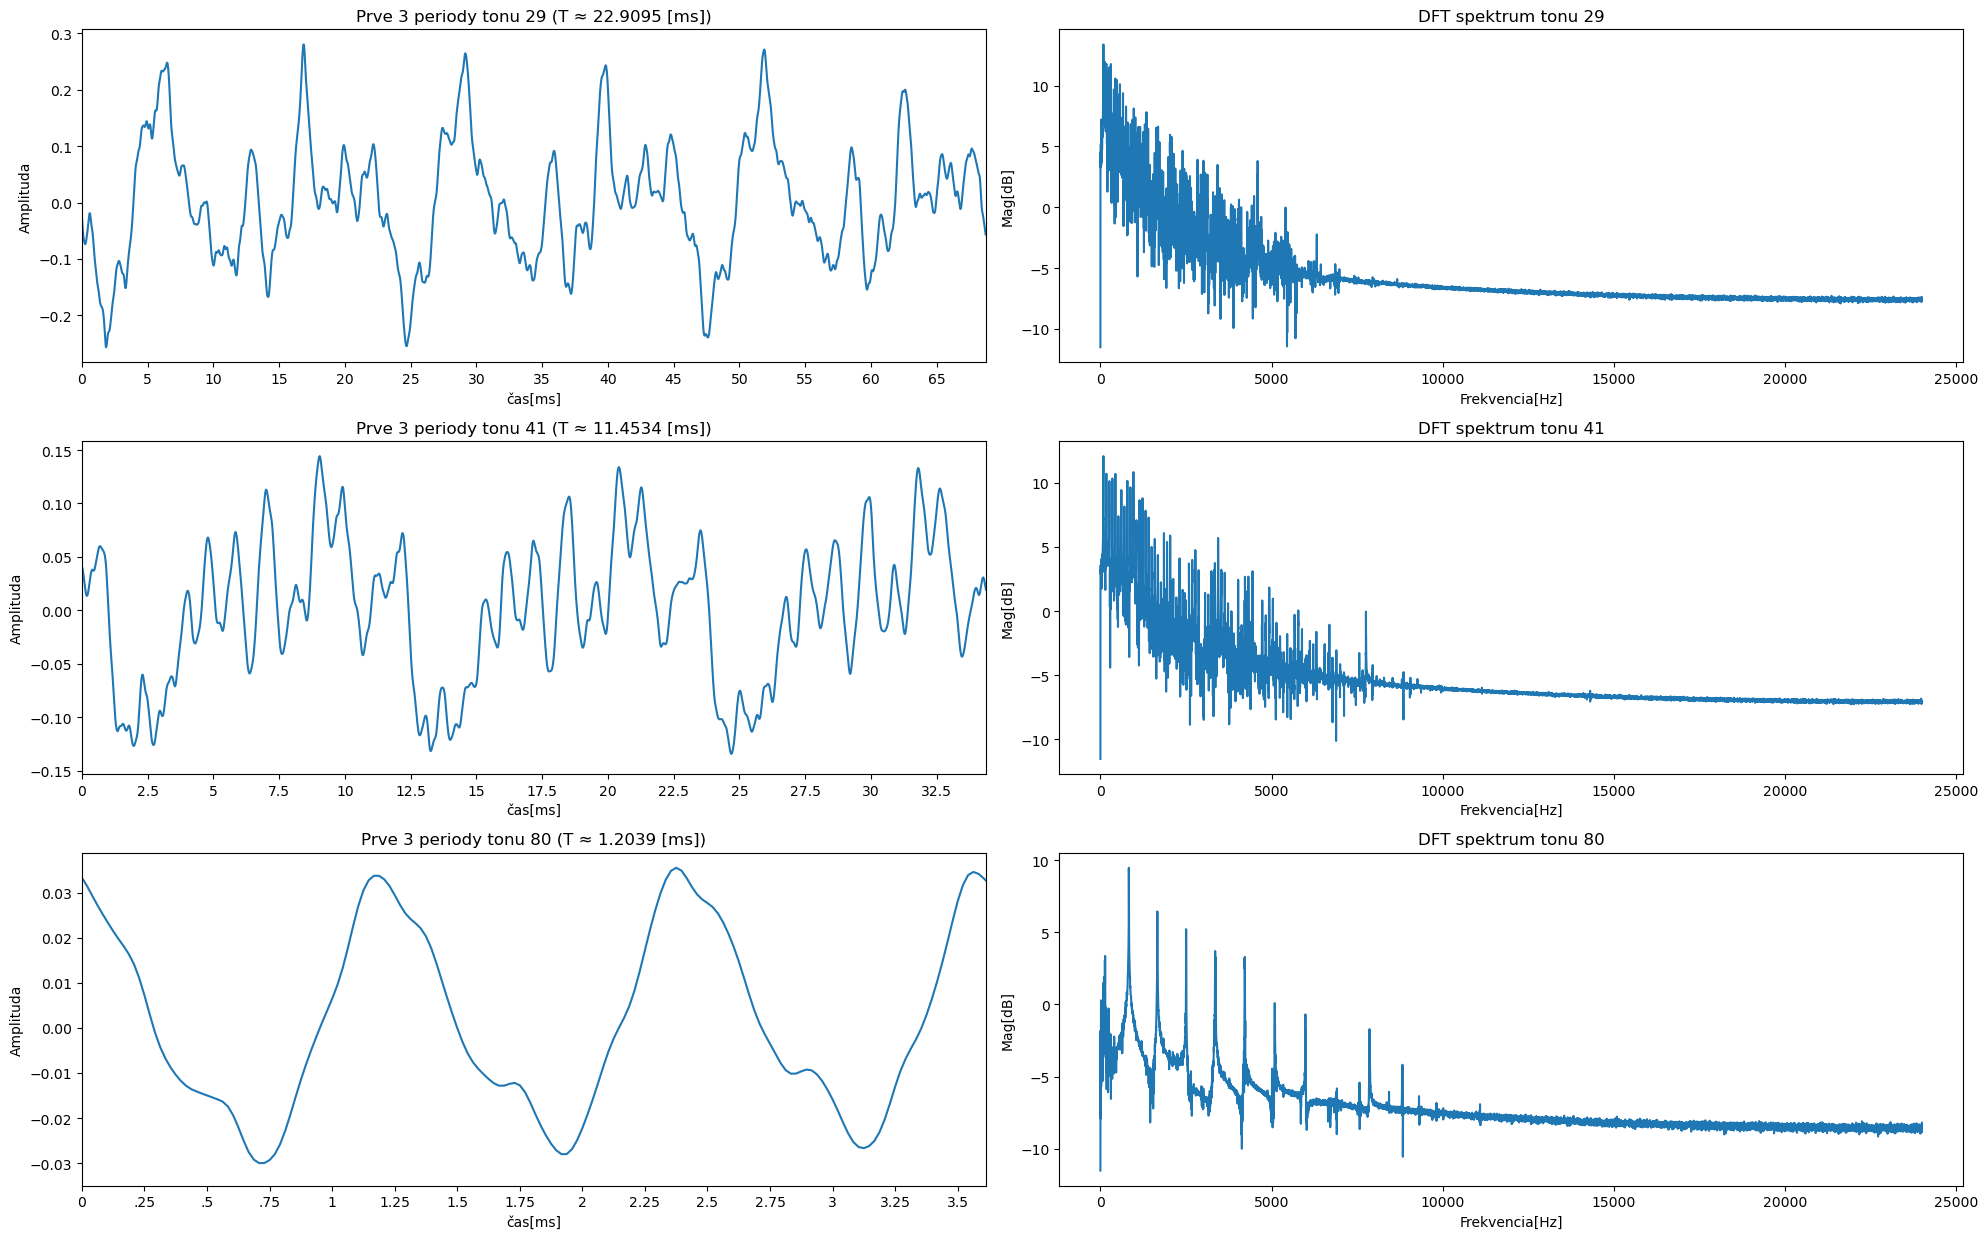

In [3]:
def plot_SIGNAL(r, c, midifreq, tone):
    T = 1 / midifreq
    segment = np.arange(xall[tone].size) / Fs
    #29; 43.65Hz
    #T = 1/43.65 = 0.0229095s*1000 = 22.9095ms
    #3*(T*Fs) ;pocet vzorkov na 3 periody
    ax[r][c].set_title('Prve 3 periody tonu %d (T ≈ %1.4f [ms])' % (tone, T*1000))
    ax[r][c].set_xlabel('čas[ms]')
    if r==0:
        ax[r][c].set_xticks((0.00, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065), 
                            ("0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50", "55", "60", "65"))
    if r==1:
        ax[r][c].set_xticks((0.000, 0.0025,0.005, 0.0075, 0.010, 0.0125, 0.015, 0.0175, 0.020, 0.0225, 0.025, 0.0275, 0.030, 0.0325), 
                            ("0", "2.5", "5", "7.5", "10", "12.5", "15", "17.5", "20", "22.5", "25", "27.5", "30", "32.5"))
    if r==2:
        ax[r][c].set_xticks((0.0000, 0.00025, 0.0005, 0.00075, 0.0010, 0.00125, 0.0015, 0.00175, 0.0020, 0.00225, 0.0025, 0.00275, 0.0030, 0.00325, 0.0035), 
                            ("0", ".25", ".5", ".75", "1", "1.25", "1.5", "1.75", "2", "2.25", "2.5", "2.75", "3", "3.25", "3.5"))
        
    ax[r][c].set_ylabel('Amplituda')
    ax[r][c].set_xlim(0, T*3)
    ax[r][c].plot(segment, xall[tone])
    
def plot_PSD(r, c, tone):
    DFT = np.fft.fft(xall[tone])
    #PSD = np.log10((np.abs(DFT)**2) + 1e-5) #np.log10((1/xall[tone].size) * (np.abs(segmentDFT)**2) + 1e-10)
    PSD = np.log(np.abs(DFT)**2 + 1e-5)
    PSDHalf = PSD[:PSD.size // 2]
    Fk = np.arange(PSDHalf.size) * (Fs / xall[tone].size)
    ax[r][c].set_title('DFT spektrum tonu %d' % tone)
    ax[r][c].set_xlabel('Frekvencia[Hz]')
    ax[r][c].set_ylabel('Mag[dB]')
    ax[r][c].plot(Fk, PSDHalf)

_, ax = plt.subplots(3, 2, figsize=(20, 12.5))

############################ TÓN 29 ############################
plot_SIGNAL(0, 0, 43.65, 29)
plot_PSD(0, 1, 29)

############################ TÓN 41 ############################
plot_SIGNAL(1, 0, 87.31, 41)
plot_PSD(1, 1, 41)

############################ TÓN 80 ############################
plot_SIGNAL(2, 0, 830.61, 80)
plot_PSD(2, 1, 80)

plt.tight_layout()

sf.write('audio/a_orig.wav', xall[29], Fs)
sf.write('audio/b_orig.wav', xall[41], Fs)
sf.write('audio/c_orig.wav', xall[80], Fs)

In [4]:
def getFreq_DFT(tone):
    DFT = np.fft.fft(xall[tone])
    N = xall[tone].size
    koeff = np.arange(0,int(N/2) + 1)
    DFTmag = np.abs(DFT[koeff])
    f = koeff / N * Fs 
    return f[np.argmax(DFTmag)]

def getFreq_ACF(tone):
    corr = signal.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):] #staci len druha polovica autokoleracie
    start = np.argmax(corr<0) #najdem vzdialenost prvej hodnoty y<0 - inak by funkcia np.argmax vzdy bola rovna 0
    peak_distance = np.argmax(corr[start:]) #argmax vrati na ktorom koeficiente sa nachadza najvyssia hodnota y                                                                                                                                                     
    freq = Fs/(peak_distance+start) 
    return freq


############################  VYPOCET POMOCI AUTOKOLERACE ############################ 
print("vypocet zakladni frekvence f0 pomoci ACF (do tonu 42)")
for tone in range(MIDIFROM, 43):
    print("f0 tonu %d: %1.3f" % (tone, getFreq_ACF(tone)))   
    
############################      VYPOCET POMOCI DFT      ############################
print("\nvypocet zakladni frekvence f0 pomoci DFT (od tonu 43)")
for tone in range(43, MIDITO+1):
    print("f0 tonu %d: %d" % (tone, getFreq_DFT(tone)))


vypocet zakladni frekvence f0 pomoci ACF (do tonu 42)
f0 tonu 24: 32.809
f0 tonu 25: 34.757
f0 tonu 26: 36.838
f0 tonu 27: 39.024
f0 tonu 28: 41.344
f0 tonu 29: 43.796
f0 tonu 30: 46.422
f0 tonu 31: 49.180
f0 tonu 32: 52.117
f0 tonu 33: 55.172
f0 tonu 34: 58.465
f0 tonu 35: 61.935
f0 tonu 36: 65.574
f0 tonu 37: 69.465
f0 tonu 38: 73.620
f0 tonu 39: 77.922
f0 tonu 40: 82.616
f0 tonu 41: 87.751
f0 tonu 42: 92.843

vypocet zakladni frekvence f0 pomoci DFT (od tonu 43)
f0 tonu 43: 97
f0 tonu 44: 104
f0 tonu 45: 110
f0 tonu 46: 118
f0 tonu 47: 124
f0 tonu 48: 130
f0 tonu 49: 138
f0 tonu 50: 146
f0 tonu 51: 156
f0 tonu 52: 164
f0 tonu 53: 350
f0 tonu 54: 370
f0 tonu 55: 391
f0 tonu 56: 208
f0 tonu 57: 220
f0 tonu 58: 234
f0 tonu 59: 248
f0 tonu 60: 262
f0 tonu 61: 278
f0 tonu 62: 294
f0 tonu 63: 312
f0 tonu 64: 330
f0 tonu 65: 350
f0 tonu 66: 370
f0 tonu 67: 391
f0 tonu 68: 416
f0 tonu 69: 440
f0 tonu 70: 465
f0 tonu 71: 493
f0 tonu 72: 524
f0 tonu 73: 554
f0 tonu 74: 588
f0 tonu 75: 622
f0 

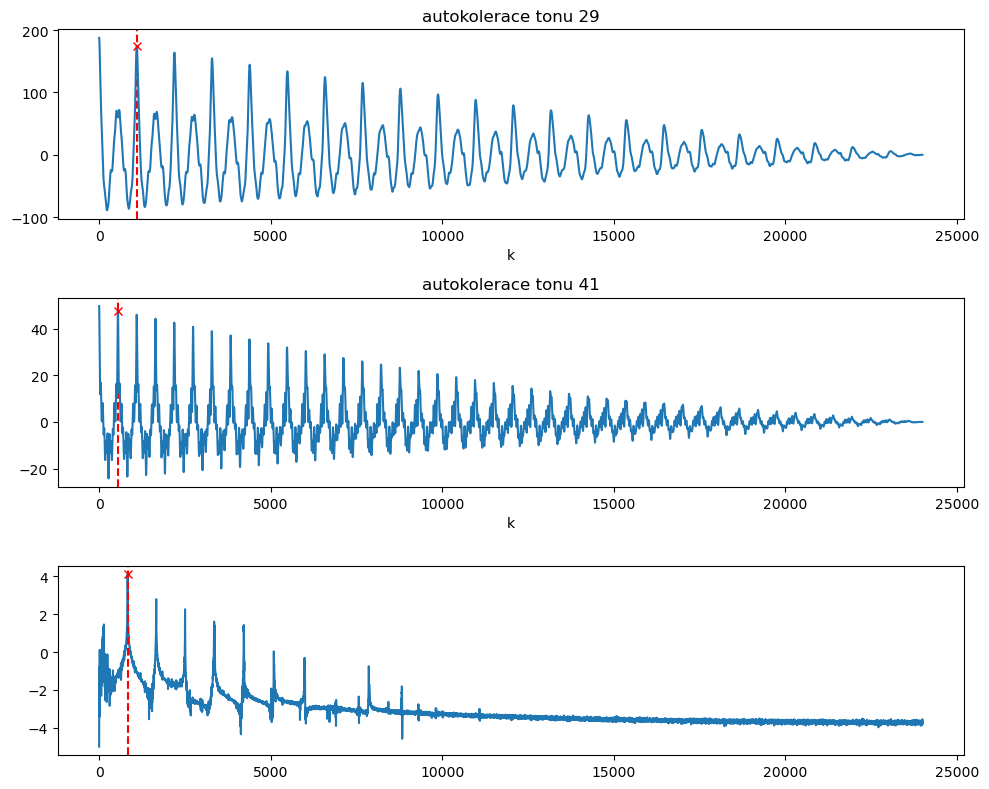

In [5]:
_, ax = plt.subplots(3, 1, figsize=(10, 8))
for idx, tone in enumerate([29, 41]):
    corr = signal.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):]
    start = np.argmax(corr<0) 
    peak_max = np.max(corr[start:]) 
    peaks = signal.find_peaks(corr[start:], height=0) 
    peak_distance = peaks[0][np.where(peaks[1]["peak_heights"] == peak_max)[0][0]]
    N = peak_distance + start
    freq = Fs/N
    ax[idx].set_title("autokolerace tonu %d" % tone)
    ax[idx].set_xlabel('k')
    ax[idx].axvline(x=N, c="r",linestyle="--")
    ax[idx].plot(corr)
    ax[idx].plot(N,corr[N], marker="x", c="r")
########################################################################################prerob na tu lepsiu verziu dft
DFT = np.fft.fft(xall[80])
DFT = np.log10(((np.abs(DFT)**2) + 1e-5))
DFTHalf = DFT[:DFT.size // 2]
Fk = np.arange(0, DFTHalf.size) * (Fs / (xall[tone].size))
peaks = signal.find_peaks(DFTHalf, height=0) #parameter height vytvori data s hodnotami magnitud
max_mag = np.max(DFTHalf) #zistim najvacsiu hodnotu magnitudy v DFT
fundamental_freq = peaks[0][np.where(peaks[1]["peak_heights"] == max_mag)[0][0]] * 2
#print(peaks[0][np.where(peaks[1]["peak_heights"] == max_mag)[0][0]])
ax[2].set_label("DFT tonu 80")
ax[2].plot(Fk, DFTHalf)
ax[2].plot(fundamental_freq, max_mag, marker="x", c="r")
ax[2].axvline(x=fundamental_freq, c="r", linestyle="--")
plt.tight_layout()



In [6]:
def getFreq_DTFT(DFT_fmax, tone, f):
    FREQRANGE = 4
    FREQPOINTS = 400
    N = 24000
    n = np.arange(0,N)
    fsweep = np.linspace(DFT_fmax-FREQRANGE, DFT_fmax+FREQRANGE,FREQPOINTS)
    
    A = np.zeros([FREQPOINTS, N],dtype=complex) 
    for k in np.arange(0,FREQPOINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)
    DTFT = np.matmul(A,xall[tone].T)
    DTFT_fmax = fsweep[np.argmax(np.abs(DTFT))] 
    
    Xmodule = np.abs(DTFT[np.argmax(np.abs(DTFT))])  
    Xphase = np.angle(DTFT[np.argmax(np.abs(DTFT))]) 

    tonedata[tone][f][2] = DTFT_fmax
    tonedata[tone][f][0] = Xmodule
    tonedata[tone][f][1] = Xphase
    
    return DTFT_fmax

tonedata = np.zeros((MIDITO+1, 5, 3)) #ton  //  f1..5 //  modul/faza/frekvencia 
                                      #tonedata[ton][fi][0] = modul v fi atd...
for tone in range(MIDIFROM, MIDITO+1):   
    if tone < 43:
        DFT_fmax = getFreq_ACF(tone)
        print("ton %d: ACF f = %1.2f\n       DTFT f = %1.2f\n" % (tone,DFT_fmax, getFreq_DTFT(DFT_fmax, tone, 0)))
    else:
        DFT_fmax = getFreq_DFT(tone)
        print("ton %d: DFT f = %1.2f\n       DTFT f = %1.2f\n" % (tone,DFT_fmax, getFreq_DTFT(DFT_fmax, tone, 0)))


ton 24: ACF f = 32.81
       DTFT f = 32.16

ton 25: ACF f = 34.76
       DTFT f = 32.54

ton 26: ACF f = 36.84
       DTFT f = 36.19

ton 27: ACF f = 39.02
       DTFT f = 38.33

ton 28: ACF f = 41.34
       DTFT f = 39.23

ton 29: ACF f = 43.80
       DTFT f = 44.37

ton 30: ACF f = 46.42
       DTFT f = 43.54

ton 31: ACF f = 49.18
       DTFT f = 46.80

ton 32: ACF f = 52.12
       DTFT f = 54.45

ton 33: ACF f = 55.17
       DTFT f = 55.58

ton 34: ACF f = 58.47
       DTFT f = 59.38

ton 35: ACF f = 61.94
       DTFT f = 61.99

ton 36: ACF f = 65.57
       DTFT f = 65.34

ton 37: ACF f = 69.46
       DTFT f = 69.07

ton 38: ACF f = 73.62
       DTFT f = 72.97

ton 39: ACF f = 77.92
       DTFT f = 77.31

ton 40: ACF f = 82.62
       DTFT f = 81.96

ton 41: ACF f = 87.75
       DTFT f = 87.70

ton 42: ACF f = 92.84
       DTFT f = 92.93

ton 43: DFT f = 98.00
       DTFT f = 98.45

ton 44: DFT f = 104.00
       DTFT f = 104.31

ton 45: DFT f = 110.00
       DTFT f = 110.51

ton 46

In [7]:
#vypocet modulov a faz pro f1...f5 pre kazdy ton(f0 je uz vypocitane)
#cas vypoctu cca ~3 min

for tone in range(MIDIFROM, MIDITO+1):
    fprecise = tonedata[tone][0][2]
    f0 = [fprecise, 2*fprecise, 3*fprecise, 4*fprecise, 5*fprecise]
    
    for f in range(1,5):
        getFreq_DTFT(f0[f], tone, f)

print("done!")

done!


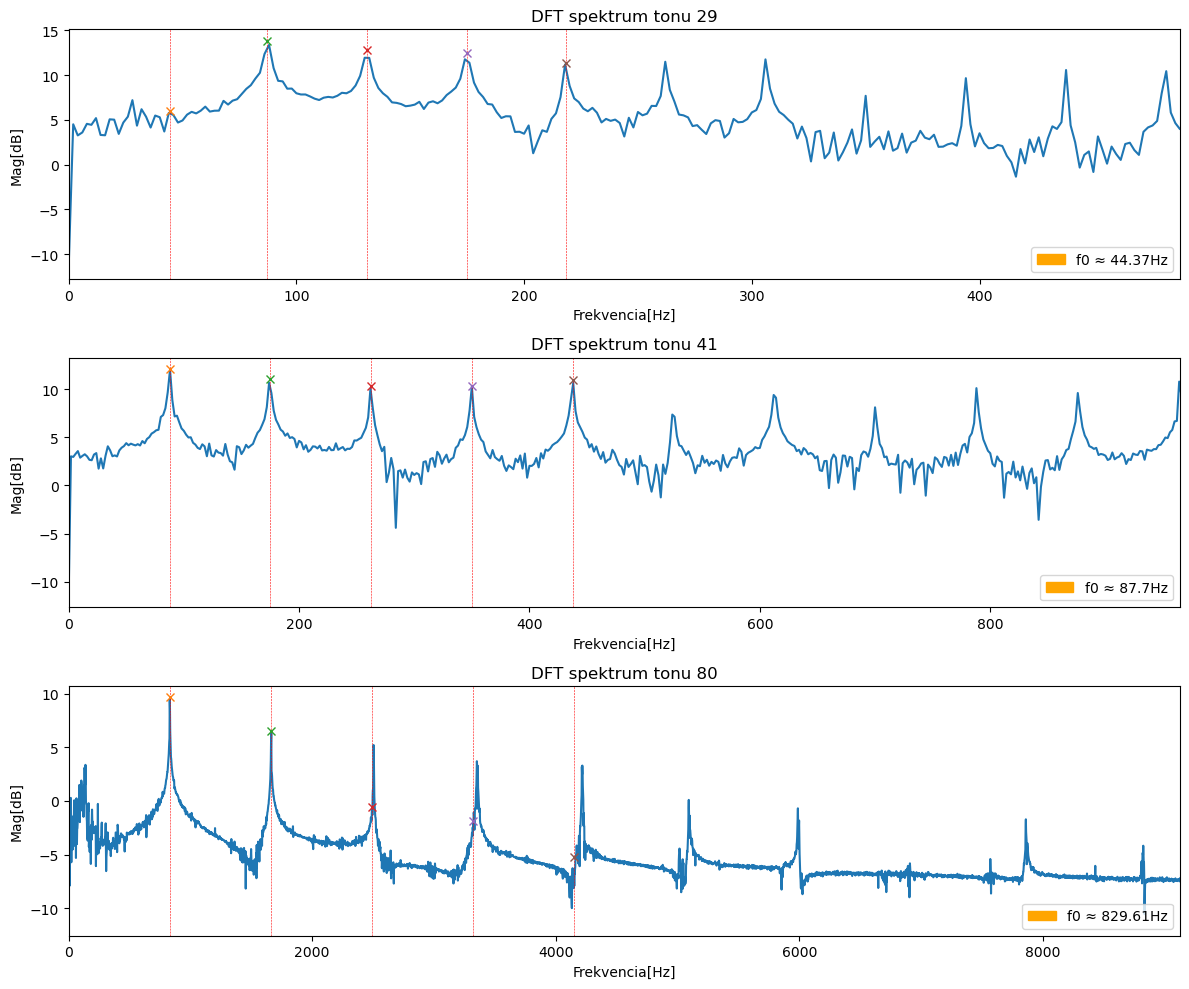

In [14]:
tones = [29, 41, 80]
def plot_fundamental(r, c, tone):
    freq0 = tonedata[tone][0][2]
    plot_PSD(r, c, tone)
    ax[r][c].set_xlim(0, 11*freq0)
    for f0 in range(5): 
        
        ax[r][c].axvline(x=tonedata[tone][f0][2], linewidth=0.4, c="r",linestyle="--")
        ax[r][c].plot(tonedata[tone][f0][2], np.log(tonedata[tone][f0][0]**2 + 1e-5), marker='x')
        flabel = mpatches.Patch(color='orange',label='f0 ≈ {}Hz'.format(round(freq0, 2)))
        ax[r][c].legend(handles=[flabel], loc='lower right')
        
_, ax = plt.subplots(3, 1, figsize=(12, 10), squeeze=False)
for idx, tone in enumerate(tones):
    plot_fundamental(idx,0,tone)
    
plt.tight_layout()

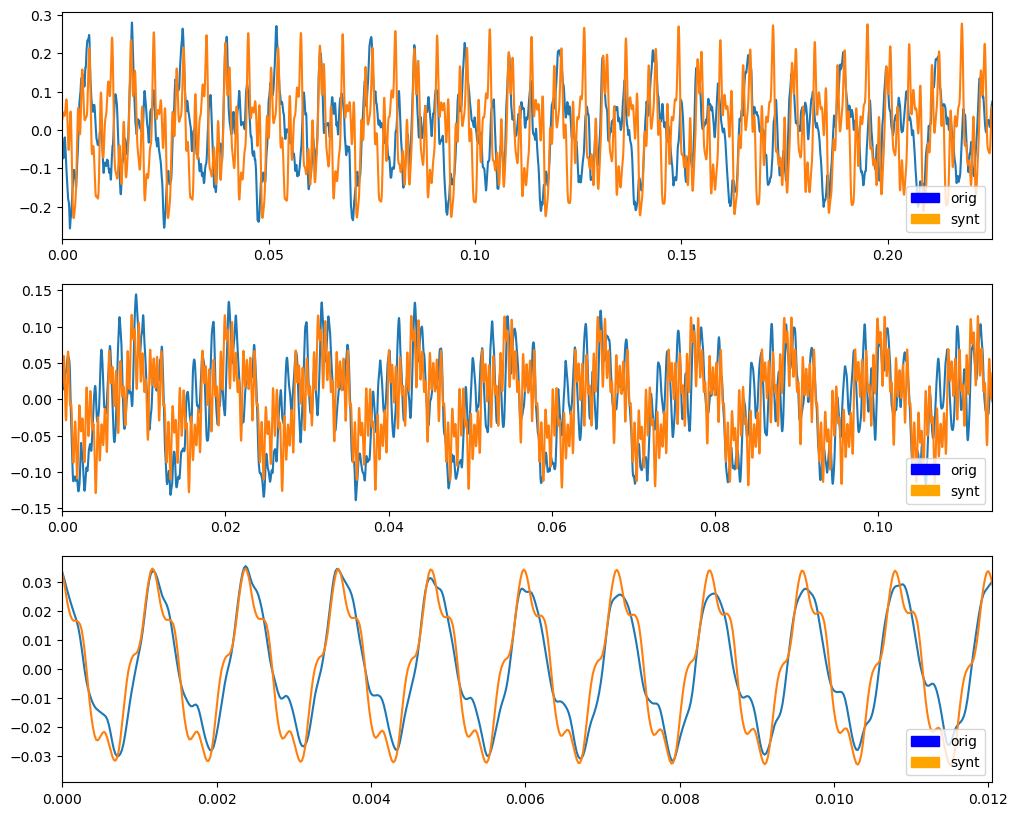

In [15]:
def synthesize_tone(tone, duration, volume=1.0, sampling_rate=48000):
    # Generate the time axis in seconds
    t = np.linspace(0, duration, int(duration * sampling_rate), False)
    # Generate the sum of five cosine waveforms
    synttone = np.real( tonedata[tone][0][0]*np.cos(2 * np.pi * 1 * tonedata[tone][0][2] * t + tonedata[tone][0][1]) + 
                        tonedata[tone][1][0]*np.cos(2 * np.pi * 2 * tonedata[tone][1][2] * t + tonedata[tone][1][1]) + 
                        tonedata[tone][2][0]*np.cos(2 * np.pi * 3 * tonedata[tone][2][2] * t + tonedata[tone][2][1]) + 
                        tonedata[tone][3][0]*np.cos(2 * np.pi * 4 * tonedata[tone][3][2] * t + tonedata[tone][3][1]) + 
                        tonedata[tone][4][0]*np.cos(2 * np.pi * 5 * tonedata[tone][4][2] * t + tonedata[tone][4][1]))
    synttone = ((synttone/max(synttone)) * max(xall[tone])) * volume #normalizacia, vynasobenie amplitudou povodnej, nastavenie hlasitosti
    return synttone

_, ax = plt.subplots(3, 1, figsize=(12, 10), squeeze=False)
blue = mpatches.Patch(color='blue', label='orig')
orange = mpatches.Patch(color='orange', label='synt')

for idx, tone in enumerate(tones):
    synttone = synthesize_tone(tone=tone, duration=1, volume=1, sampling_rate=Fs)

    
    segment = np.arange(xall[tone].size) / Fs
    T = 1/tonedata[tone][0][2]

    if idx == 0:
        ax[0][0].plot(segment, xall[tone])
        ax[0][0].plot(segment, synttone[993:24993])
        ax[0][0].legend(handles=[blue, orange], loc='lower right')
        ax[0][0].set_xlim(0, 10*T)
        
        sf.write('audio/a.wav', synttone, Fs)
    if idx == 1:
        ax[1][0].plot(segment, xall[tone])
        ax[1][0].plot(segment, synttone[1068:25068])
        ax[1][0].legend(handles=[blue, orange], loc='lower right')
        ax[1][0].set_xlim(0, 10*T)
        
        sf.write('audio/b.wav', synttone, Fs)
    if idx == 2:
        ax[2][0].plot(segment, xall[tone])
        ax[2][0].plot(segment, synttone[1:24001])
        ax[2][0].legend(handles=[blue, orange], loc='lower right')
        ax[2][0].set_xlim(0, 10*T)
        
        sf.write('audio/c.wav', synttone, Fs)

In [11]:
def generate_song(filename='skladba.txt', Fs=48000):
    songdata = np.loadtxt(filename)
    #        songdata[row][column] 
    #     od      do     midi   hlasitost
    #     0       1       2        3
    linecount = songdata.shape[0]
    #najdi najvyssiu hodnotu do -> prepocitaj podla Fs -> toto bude velkost skladby
    songsize = songdata[0][1]
    for line in range(1, linecount):
        songsize_next = songdata[line][1]
        if songsize_next > songsize:
            songsize = songsize_next

    songsize = int((songsize / 1000) * Fs)
    song = np.zeros(songsize)

    for line in range(linecount):
        midi = int(songdata[line][2])
        dstart = int(songdata[line][0])
        indexstart = int(dstart/1000 * Fs)
        dend = int(songdata[line][1])
        duration = (dend - dstart) / 1000
        volume = songdata[line][3] / 100

        synttone = synthesize_tone(tone=midi, duration=duration, volume=volume, sampling_rate=Fs)
        for j in range(synttone.size):
            song[indexstart+j] += synttone[j]
    
    return song

song8k = generate_song('skladba.txt', 8000)
song48k = generate_song('skladba.txt', 48000)
sf.write('audio/out_8k.wav', song8k, 8000)
sf.write('audio/out_48k.wav', song48k, 48000)
    